# SATB2
[Glass syndrome (GLASS)](https://omim.org/entry/612313) is caused by heterozygous interstitial deletion on chromosome 2q32-q33. The disorder can also be caused by heterozygous mutation in the SATB2 gene (608148), which is within the Glass syndrome chromosome region.

In [17]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using genophenocorr version {gpsea.__version__}")

Loaded HPO v2023-10-09
Using genophenocorr version 0.9.2


### SATB2
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for NKX6-2.

In [18]:
gene_symbol = 'SATB2'
mane_tx_id = 'NM_001172509.2'
mane_protein_id = 'NP_001165980.1' # DNA-binding protein SATB2

In [19]:
from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.23") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
print(f'Loaded {len(phenopackets)} phenopackets from {gene_symbol}')

from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets
cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
validation.summarize()

Loaded 158 phenopackets from SATB2
Individuals Processed: 100%|██████████| 158/158 [00:36<00:00,  4.32 individuals/s]
Validated under permissive policy
No errors or warnings were found


In [20]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
157,Global developmental delay
135,Abnormality of the dentition
107,Intellectual disability
89,Feeding difficulties in infancy
89,Delayed ability to walk
75,Delayed speech and language development
70,Cleft palate
50,Brain imaging abnormality
44,Growth delay
33,Reduced bone mineral density


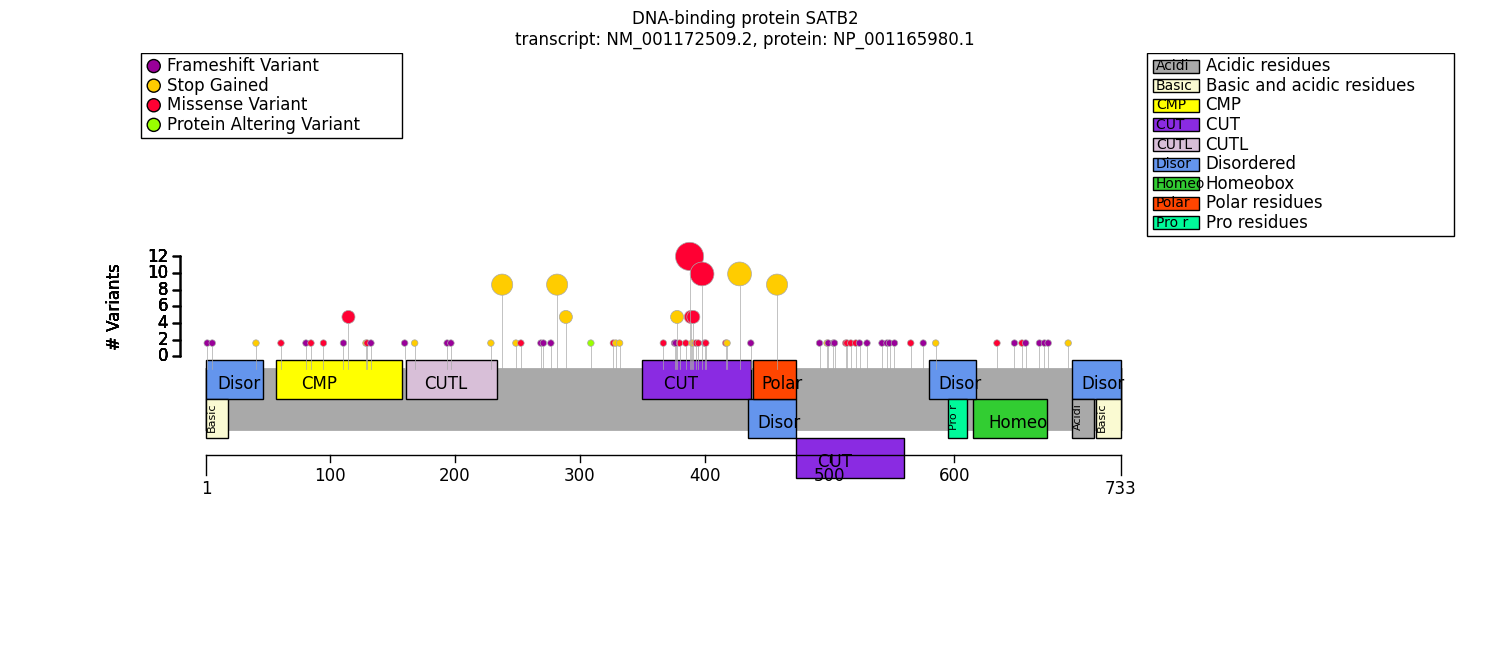

In [21]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

satb2_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
satb2_fig.tight_layout()

In [22]:
from gpsea.view import ProteinVariantViewer

viewer = ProteinVariantViewer(protein_meta, mane_tx_id)
viewer.process(cohort)

Count,Name,Type,Coordinates,Variants
3,Disordered,Region,2 - 47,p.Gly42Ter; p.Ser7LysfsTer68; p.Arg4GlufsTer68
2,Basic and acidic residues,Compositional bias,2 - 19,p.Ser7LysfsTer68; p.Arg4GlufsTer68
10,CMP,Domain,58 - 158,p.Ala134HisfsTer17; p.Gly116Arg; p.Tyr130Ter; p.Leu96Arg; p.Ala82GlyfsTer30; p.Ala112ProfsTer6; p.Gly116Ter; p.Leu86Arg; p.Val62Asp; p.Val131Glu
4,CUTL,Domain,162 - 234,p.Gln169Ter; p.Cys195LeufsTer14; p.Gln199GlufsTer9; p.Lys230Ter
46,CUT 1,DNA binding,351 - 437,p.Arg399Leu; p.Leu394Ser; p.Gln419Ter; p.Arg429Ter; p.Gln391Ter; p.Ala386Val; p.Ser378ProfsTer18; p.Gly392Arg; p.Arg389Leu; p.Gln379Pro; p.Glu402ArgfsTer35; p.Gln379Ter; p.Glu402Lys; p.Val368Phe; p.Arg429Gln; p.Arg399Pro; p.Gly392Glu; p.Glu396Gln; p.Arg399LeufsTer14; p.Val381Gly; p.Met418Arg; p.Arg389Cys; p.Thr390Ile; p.Ser378TyrfsTer36; p.Arg399His
7,Disordered,Region,436 - 473,p.Arg439GlyfsTer38; p.Arg459Ter
6,Polar residues,Compositional bias,440 - 473,p.Arg459Ter
15,CUT 2,DNA binding,474 - 560,p.Lys499Ter; p.Arg522Cys; p.Asn531LysfsTer21; p.Phe505LeufsTer41; p.Arg543AlafsTer3; p.Glu525GlyfsTer21; p.Leu547PhefsTer77; p.Asp553MetfsTer71; p.Gly515Ser; p.Gln549SerfsTer75; p.Gln493ArgfsTer19; p.Val500CysfsTer46; p.Cys518Trp; p.Phe505LysfsTer10; p.Gln514Arg
1,Disordered,Region,581 - 617,p.Gln586Ter
0,Pro residues,Compositional bias,596 - 610,


In [23]:
from gpsea.view import CohortVariantViewer

viewer = CohortVariantViewer(tx_id=mane_tx_id)
viewer.process(cohort)

Count,Variant key,HGVS,Overlapping Exons,Effects
22,SO:1000029_HGNC:21637_SATB2,SV involving SATB2 (p.?),,chromosomal deletion
10,2_199348709_199348709_G_A,c.1165C>T (p.Arg389Cys),7,missense
6,2_199349027_199349027_G_A,c.847C>T (p.Arg283Ter),7,stop gained
6,2_199349159_199349159_G_A,c.715C>T (p.Arg239Ter),7,stop gained
6,2_199328709_199328709_G_A,c.1375C>T (p.Arg459Ter),8,stop gained
6,SO:1000044_HGNC:21637_SATB2,SV involving SATB2 (p.?),,chromosomal_translocation
4,2_199328799_199328799_G_A,c.1285C>T (p.Arg429Ter),8,stop gained
4,2_199328888_199328888_C_T,c.1196G>A (p.Arg399His),8,missense
4,2_199328798_199328798_C_T,c.1286G>A (p.Arg429Gln),8,missense
3,SO:1000037_HGNC:21637_SATB2,SV involving SATB2 (p.?),,chromosomal duplication


## Genotype-Phenotype Correlation (GPC) Analysis


In [24]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [25]:
from gpsea.analysis.predicate import variant_effect
from gpsea.analysis.clf import monoallelic_classifier
from gpsea.model import VariantEffect
from gpsea.view import MtcStatsViewer

is_missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

missense_clf = monoallelic_classifier(
   a_predicate=is_missense,
   b_predicate=~is_missense,
   a_label="Missense",
   b_label="Other"
)
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,2
HMF03,Skipping term because of a child term with the same individual counts,4
HMF08,Skipping general term,14
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,4


In [26]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group                                       Missense            Other  \
                                                      Count Percent    Count   
Cleft palate [HP:0000175]                             11/49     22%   59/105   
Feeding difficulties in infancy [HP:0008872]          24/40     60%    65/90   
Delayed ability to walk [HP:0031936]                  33/41     80%    56/80   
Abnormality of the dentition [HP:0000164]             39/40     98%    96/97   
Feeding difficulties [HP:0011968]                     24/24    100%    65/65   
Delayed speech and language development [HP:000...    20/21     95%    55/57   
Neurodevelopmental delay [HP:0012758]                 49/49    100%  108/108   
Neurodevelopmental abnormality [HP:0012759]           49/49    100%  108/108   
Language impairment [HP:0002463]                      20/20    100%    55/55   
Abnormal communication [HP:0034434]                   20/20    100%    55/55   
Abnormality of speech or vocalization [HP:0002167]    20/20    100%    55/55   
Intellectual disability [HP:0001249]                  34/34    100%    73/73   
Global developmental delay [HP:0001263]               49/49    100%  108/108   
Brain imaging abnormality [HP:0410263]                18/39     46%    32/69   
Abnormal oral cavity morphology [HP:0000163]          44/44    100%  102/102   
Orofacial cleft [HP:0000202]                          11/11    100%    59/59   
Abnormal palate morphology [HP:0000174]               11/11    100%    59/59   
Delayed gross motor development [HP:0002194]          33/33    100%    56/56   

Allele group                                                                   \
                                                   Percent Corrected p values   
Cleft palate [HP:0000175]                              56%           0.001993   
Feeding difficulties in infancy [HP:0008872]           72%           1.000000   
Delayed ability to walk [HP:0031936]                   70%           1.000000   
Abnormality of the dentition [HP:0000164]              99%           1.000000   
Feeding difficulties [HP:0011968]                     100%           1.000000   
Delayed speech and language development [HP:000...     96%           1.000000   
Neurodevelopmental delay [HP:0012758]                 100%           1.000000   
Neurodevelopmental abnormality [HP:0012759]           100%           1.000000   
Language impairment [HP:0002463]                      100%           1.000000   
Abnormal communication [HP:0034434]                   100%           1.000000   
Abnormality of speech or vocalization [HP:0002167]    100%           1.000000   
Intellectual disability [HP:0001249]                  100%           1.000000   
Global developmental delay [HP:0001263]               100%           1.000000   
Brain imaging abnormality [HP:0410263]                 46%           1.000000   
Abnormal oral cavity morphology [HP:0000163]          100%           1.000000   
Orofacial cleft [HP:0000202]                          100%           1.000000   
Abnormal palate morphology [HP:0000174]               100%           1.000000   
Delayed gross motor development [HP:0002194]          100%           1.000000   

Allele group                                                  
                                                    p values  
Cleft palate [HP:0000175]                           0.000111  
Feeding difficulties in infancy [HP:0008872]        0.219640  
Delayed ability to walk [HP:0031936]                0.277877  
Abnormality of the dentition [HP:0000164]           0.500215  
Feeding difficulties [HP:0011968]                   1.000000  
Delayed speech and language development [HP:000...  1.000000  
Neurodevelopmental delay [HP:0012758]               1.000000  
Neurodevelopmental abnormality [HP:0012759]         1.000000  
Language impairment [HP:0002463]                    1.000000  
Abnormal communication [HP:0034434]                 1.000000  
Abnormality of speech 

In [27]:
from gpsea.analysis.predicate import protein_feature

uld = protein_feature(feature_id="Homeobox", protein_metadata=protein_meta)

uld_predicate = monoallelic_classifier(
   a_predicate=uld,
   b_predicate=~uld,
   a_label="ULD",
   b_label="Other"
)
uld_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=uld_predicate,
    pheno_clfs=pheno_clfs,
)


summarize_hpo_analysis(hpo=hpo, result=uld_result)


Allele group                                         ULD            Other  \
                                                   Count Percent    Count   
Cleft palate [HP:0000175]                            4/6     67%   66/148   
Delayed ability to walk [HP:0031936]                 3/5     60%   86/116   
Brain imaging abnormality [HP:0410263]               3/5     60%   47/103   
Feeding difficulties in infancy [HP:0008872]         5/6     83%   84/124   
Feeding difficulties [HP:0011968]                    5/5    100%    84/84   
Delayed speech and language development [HP:000...   3/3    100%    72/75   
Neurodevelopmental delay [HP:0012758]                6/6    100%  151/151   
Neurodevelopmental abnormality [HP:0012759]          6/6    100%  151/151   
Language impairment [HP:0002463]                     3/3    100%    72/72   
Abnormal communication [HP:0034434]                  3/3    100%    72/72   
Abnormality of speech or vocalization [HP:0002167]   3/3    100%    72/72   
Intellectual disability [HP:0001249]                 5/5    100%  102/102   
Global developmental delay [HP:0001263]              6/6    100%  151/151   
Abnormality of the dentition [HP:0000164]            5/5    100%  130/132   
Abnormal oral cavity morphology [HP:0000163]         6/6    100%  140/140   
Orofacial cleft [HP:0000202]                         4/4    100%    66/66   
Abnormal palate morphology [HP:0000174]              4/4    100%    66/66   
Delayed gross motor development [HP:0002194]         3/3    100%    86/86   

Allele group                                                                   \
                                                   Percent Corrected p values   
Cleft palate [HP:0000175]                              45%                1.0   
Delayed ability to walk [HP:0031936]                   74%                1.0   
Brain imaging abnormality [HP:0410263]                 46%                1.0   
Feeding difficulties in infancy [HP:0008872]           68%                1.0   
Feeding difficulties [HP:0011968]                     100%                1.0   
Delayed speech and language development [HP:000...     96%                1.0   
Neurodevelopmental delay [HP:0012758]                 100%                1.0   
Neurodevelopmental abnormality [HP:0012759]           100%                1.0   
Language impairment [HP:0002463]                      100%                1.0   
Abnormal communication [HP:0034434]                   100%                1.0   
Abnormality of speech or vocalization [HP:0002167]    100%                1.0   
Intellectual disability [HP:0001249]                  100%                1.0   
Global developmental delay [HP:0001263]               100%                1.0   
Abnormality of the dentition [HP:0000164]              98%                1.0   
Abnormal oral cavity morphology [HP:0000163]          100%                1.0   
Orofacial cleft [HP:0000202]                          100%                1.0   
Abnormal palate morphology [HP:0000174]               100%                1.0   
Delayed gross motor development [HP:0002194]          100%                1.0   

Allele group                                                  
                                                    p values  
Cleft palate [HP:0000175]                           0.411718  
Delayed ability to walk [HP:0031936]                0.606967  
Brain imaging abnormality [HP:0410263]              0.660905  
Feeding difficulties in infancy [HP:0008872]        0.664264  
Feeding difficulties [HP:0011968]                   1.000000  
Delayed speech and language development [HP:000...  1.000000  
Neurodevelopmental delay [HP:0012758]               1.000000  
Neurodevelopmental abnormality [HP:0012759]         1.000000  
Language impairment [HP:0002463]                    1.000000  
Abnormal communication [HP:0034434]                 1.000000  
Abnormality of speech or vocalization [HP:0002167]  1.000000  
Intellectual disabi

In [28]:
from gpsea.analysis.clf import sex_classifier

mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=mf_result)

Sex                                                FEMALE           MALE  \
                                                    Count Percent  Count   
Feeding difficulties in infancy [HP:0008872]        31/53     58%  58/77   
Cleft palate [HP:0000175]                           24/62     39%  43/88   
Delayed ability to walk [HP:0031936]                31/45     69%  57/75   
Brain imaging abnormality [HP:0410263]              19/46     41%  31/61   
Abnormality of the dentition [HP:0000164]           54/54    100%  79/81   
Delayed speech and language development [HP:000...  33/35     94%  42/43   
Feeding difficulties [HP:0011968]                   31/31    100%  58/58   
Neurodevelopmental delay [HP:0012758]               61/61    100%  90/90   
Neurodevelopmental abnormality [HP:0012759]         61/61    100%  90/90   
Language impairment [HP:0002463]                    33/33    100%  42/42   
Abnormal communication [HP:0034434]                 33/33    100%  42/42   
Abnormality of speech or vocalization [HP:0002167]  33/33    100%  42/42   
Intellectual disability [HP:0001249]                41/41    100%  64/64   
Global developmental delay [HP:0001263]             61/61    100%  90/90   
Abnormal oral cavity morphology [HP:0000163]        58/58    100%  83/83   
Orofacial cleft [HP:0000202]                        24/24    100%  43/43   
Abnormal palate morphology [HP:0000174]             24/24    100%  43/43   
Delayed gross motor development [HP:0002194]        31/31    100%  57/57   

Sex                                                                            \
                                                   Percent Corrected p values   
Feeding difficulties in infancy [HP:0008872]           75%           0.988717   
Cleft palate [HP:0000175]                              49%           1.000000   
Delayed ability to walk [HP:0031936]                   76%           1.000000   
Brain imaging abnormality [HP:0410263]                 51%           1.000000   
Abnormality of the dentition [HP:0000164]              98%           1.000000   
Delayed speech and language development [HP:000...     98%           1.000000   
Feeding difficulties [HP:0011968]                     100%           1.000000   
Neurodevelopmental delay [HP:0012758]                 100%           1.000000   
Neurodevelopmental abnormality [HP:0012759]           100%           1.000000   
Language impairment [HP:0002463]                      100%           1.000000   
Abnormal communication [HP:0034434]                   100%           1.000000   
Abnormality of speech or vocalization [HP:0002167]    100%           1.000000   
Intellectual disability [HP:0001249]                  100%           1.000000   
Global developmental delay [HP:0001263]               100%           1.000000   
Abnormal oral cavity morphology [HP:0000163]          100%           1.000000   
Orofacial cleft [HP:0000202]                          100%           1.000000   
Abnormal palate morphology [HP:0000174]               100%           1.000000   
Delayed gross motor development [HP:0002194]          100%           1.000000   

Sex                                                           
                                                    p values  
Feeding difficulties in infancy [HP:0008872]        0.054929  
Cleft palate [HP:0000175]                           0.245526  
Delayed ability to walk [HP:0031936]                0.402722  
Brain imaging abnormality [HP:0410263]              0.433938  
Abnormality of the dentition [HP:0000164]           0.516418  
Delayed speech and language development [HP:000...  0.584560  
Feeding difficulties [HP:0011968]                   1.000000  
Neurodevelopmental delay [HP:0012758]               1.000000  
Neurodevelopmental abnormality [HP:0012759]         1.000000  
Language impairment [HP:0002463]                    1.000000  
Abnormal communication [HP:0034434]                 1.000000  
Abnormality of speech or vocalization [

In [29]:
ablation = variant_effect(effect=VariantEffect.TRANSCRIPT_ABLATION, tx_id=mane_tx_id)

ablation_clf = monoallelic_classifier(
    a_predicate=ablation,
    b_predicate=~ablation,
    a_label="transcript ablation",
    b_label="other"
)
ablation_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=ablation_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=ablation_result)


Allele group                                       transcript ablation  \
                                                                 Count   
Feeding difficulties in infancy [HP:0008872]                     12/22   
Delayed ability to walk [HP:0031936]                             10/15   
Brain imaging abnormality [HP:0410263]                            4/11   
Cleft palate [HP:0000175]                                        11/22   
Feeding difficulties [HP:0011968]                                12/12   
Delayed speech and language development [HP:000...                 8/8   
Neurodevelopmental delay [HP:0012758]                            21/21   
Neurodevelopmental abnormality [HP:0012759]                      21/21   
Language impairment [HP:0002463]                                   8/8   
Abnormal communication [HP:0034434]                                8/8   
Abnormality of speech or vocalization [HP:0002167]                 8/8   
Intellectual disability [HP:0001249]                             13/13   
Global developmental delay [HP:0001263]                          21/21   
Abnormality of the dentition [HP:0000164]                        18/18   
Abnormal oral cavity morphology [HP:0000163]                     19/19   
Orofacial cleft [HP:0000202]                                     11/11   
Abnormal palate morphology [HP:0000174]                          11/11   
Delayed gross motor development [HP:0002194]                     10/10   

Allele group                                                  other          \
                                                   Percent    Count Percent   
Feeding difficulties in infancy [HP:0008872]           55%   77/108     71%   
Delayed ability to walk [HP:0031936]                   67%   79/106     75%   
Brain imaging abnormality [HP:0410263]                 36%    46/97     47%   
Cleft palate [HP:0000175]                              50%   59/132     45%   
Feeding difficulties [HP:0011968]                     100%    77/77    100%   
Delayed speech and language development [HP:000...    100%    67/70     96%   
Neurodevelopmental delay [HP:0012758]                 100%  136/136    100%   
Neurodevelopmental abnormality [HP:0012759]           100%  136/136    100%   
Language impairment [HP:0002463]                      100%    67/67    100%   
Abnormal communication [HP:0034434]                   100%    67/67    100%   
Abnormality of speech or vocalization [HP:0002167]    100%    67/67    100%   
Intellectual disability [HP:0001249]                  100%    94/94    100%   
Global developmental delay [HP:0001263]               100%  136/136    100%   
Abnormality of the dentition [HP:0000164]             100%  117/119     98%   
Abnormal oral cavity morphology [HP:0000163]          100%  127/127    100%   
Orofacial cleft [HP:0000202]                          100%    59/59    100%   
Abnormal palate morphology [HP:0000174]               100%    59/59    100%   
Delayed gross motor development [HP:0002194]          100%    79/79    100%   

Allele group                                                           \
                                                   Corrected p values   
Feeding difficulties in infancy [HP:0008872]                      1.0   
Delayed ability to walk [HP:0031936]                              1.0   
Brain imaging abnormality [HP:0410263]                            1.0   
Cleft palate [HP:0000175]                                         1.0   
Feeding difficulties [HP:0011968]                                 1.0   
Delayed speech and language development [HP:000...                1.0   
Neurodevelopmental delay [HP:0012758]                             1.0   
Neurodevelopmental abnormality [HP:0012759]                       1.0   
Language impairment [HP:0002463]                                  1.0   
Abnormal communication [HP:0034434]                               1.0   
Abnormality of speech or vocalization [HP:0002167]            

In [30]:
from gpsea.analysis.pscore import DeVriesPhenotypeScorer
from gpsea.analysis.pscore.stats import MannWhitneyStatistic
from gpsea.analysis.pscore import PhenotypeScoreAnalysis

score_statistic = MannWhitneyStatistic()
score_analysis = PhenotypeScoreAnalysis(
    score_statistic=score_statistic,
)

pheno_scorer = DeVriesPhenotypeScorer(hpo)
result = score_analysis.compare_genotype_vs_phenotype_score(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_scorer=pheno_scorer,
)
result.pval

0.5113126322400692

# Summary

In [31]:
from gpseacs.report import  GPAnalysisResultSummary, GpseaAnalysisReport

fet_results = (
    GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ),
     GPAnalysisResultSummary.from_multi(
        result=uld_result,
    ),
     GPAnalysisResultSummary.from_multi(
        result=mf_result,
    ),
     GPAnalysisResultSummary.from_multi(
        result=ablation_result,
    ),
)

caption="""). Individuals with large chromosomal deletions were diagnosedat earlier ages (mean 2.5 years, p ≤ 0.0006). Individuals with missense ordisruptive pathogenic variants were more commonly reported to havesialorrhea (p = 0.0115), and those with large deletions were more likelyto have a history of growth retardation (p = 0.0033)
The authors reported a higher prevalence of chronic mucocutanous candidiasis with the variant Arg357Ter than with other 
    variants. We did not identify a significant difference in prevalence \\cite{PMID_29436146}"""

report = GpseaAnalysisReport(
    name=gene_symbol,
    cohort=cohort,
    fet_results=fet_results,
    gene_symbol=gene_symbol,
    mane_tx_id=mane_tx_id,
    mane_protein_id=mane_protein_id,
    caption=caption)


In [32]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [ ]:
summarizer.process_latex(report=report, protein_fig=satb2_fig)